## Observations
1. Our gradient estimates at known sample locations are large when we resample at the sample location in our trajectory.

In [ ]:
using LinearAlgebra
using Plots
using Random

In [ ]:
include("../rollout.jl")
include("../testfns.jl")
include("../utils.jl")

stochastic_gradient_ascent_adam (generic function with 1 method)

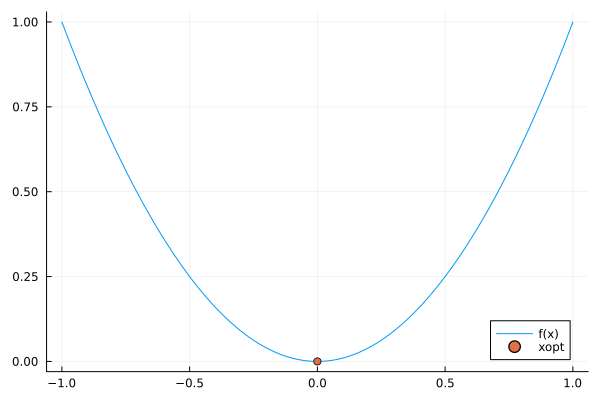

In [3]:
# testfn = TestLinearCosine1D(1, 25, lb=0., ub=2)
testfn = TestQuadratic1D(1., 0., 0.; lb=-1., ub=1.)
# testfn = TestConstant(0., lbs=[0.], ubs=[1.])
# testfn = TestGramacyLee()
tplot(testfn)

In [4]:
Random.seed!(1906)

n, h, σn2 = 1, 0, 1e-6
MC_SAMPLES = 50
# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, h+1);
rns = randn(MC_SAMPLES, testfn.dim+1, h+1);
xmin, xmax, d = (testfn.bounds[1], testfn.bounds[2], size(testfn.bounds, 1))
θ = [1.]
ψ = kernel_matern52(θ)
# ψ = kernel_scale(kernel_matern52, [5., θ...])

lbs, ubs = [xmin], [xmax]
ϵ, num_starts = 1e-6, 4
s = SobolSeq(lbs, ubs)

xstarts = reduce(hcat, next!(s) for i = 1:num_starts)
xstarts = hcat(xstarts, lbs .+ ϵ)
xstarts = hcat(xstarts, ubs .- ϵ);

### Dense Experiments in 1D for Rollout Acquisition Functions
We'll do a comparative analysis, visually, of the structure of the rollout acquisition function in 1D for horizons 0 and 1.

In [17]:
"""
TODO: We need to specify the maximum number of iterations and terminate if we exhaust our budget
TODO: EI for Rosenbrock looks like zeros everywhere, depending on how we sample. I suspect this
is why our algorithm halts here.
"""

function ei_solver(s::RBFsurrogate, lbs, ubs, initial_guesses; max_iterations=100)
    ei_solver_unrolled(minimum(get_observations(s)), s.EI, s.∇EI, s.HEI; (lbs, ubs, initial_guesses, max_iterations))
end

function ei_solver_unrolled(X, L, c, y; optimization_hyperparams)
    (lbs, ubs, initial_guesses, max_iterations) = optimization_hyperparams
    
end

function ei_solver(s::RBFsurrogate, lbs, ubs, initial_guesses; max_iterations=100)
    fbest = minimum(get_observations(s))

    function ei(x)
        sx = s(x)
        if sx.σ < 1e-6 return 0 end
        return -sx.EI
    end

    function ei_grad!(g, x)
        EIx = -s(x).∇EI
        for i in eachindex(EIx)
            g[i] = EIx[i]
        end
    end

    function ei_hessian!(h, x)
        HEIx = -s(x).HEI
        for row in 1:size(HEIx, 1)
            for col in 1:size(HEIx, 2)
                h[row, col] = HEIx[row, col]
            end
        end
    end

    final_minimizer = (initial_guesses[:, 1], Inf)
    
    for j in 1:size(initial_guesses, 2)
        initial_guess = initial_guesses[:, j]
        df = TwiceDifferentiable(ei, ei_grad!, ei_hessian!, initial_guess)
        dfc = TwiceDifferentiableConstraints(lbs, ubs)
        result = optimize(df, dfc, initial_guess, IPNewton(), Optim.Options(iterations=max_iterations))
        cur_minimizer, cur_minimum = Optim.minimizer(result), Optim.minimum(result)

        if cur_minimum < final_minimizer[2]
            final_minimizer = (cur_minimizer, cur_minimum)
        end
    end
    
    return final_minimizer[2]
end

# Initialize surrogate model
Xinit = [1.5;; 2.0;;]
yinit = testfn(Xinit)
sur_ei = fit_surrogate(ψ, Xinit, yinit; σn2=σn2)
sur_ei = optimize_hypers_optim(sur_ei, kernel_matern52)

# Solve the acquisition function
# xnext, fnext = ei_solver(sur_ei, lbs, ubs, xstarts)
ei_solver(sur_ei, lbs, ubs, xstarts)
# ynext = testfn(xnext)
# # Update the surrogate model
# sur_ei = update_surrogate(sur_ei, xnext, ynext)
# sur_ei = optimize_hypers_optim(sur_ei, kernel_matern52)

-0.1052418444365388

In [18]:
using Zygote

In [19]:
gradient(ei_solver, sur_ei, lbs, ubs, xstarts)

LoadError: Can't differentiate foreigncall expression $(Expr(:foreigncall, :(:jl_clock_now), Float64, svec(), 0, :(:ccall))).
You might want to check the Zygote limitations documentation.
https://fluxml.ai/Zygote.jl/latest/limitations


In [ ]:
gradient(ei_solver, sur_ei, lbs, ubs; initial_guesses=xstarts)